In [64]:
import pandas as pd

df = pd.read_csv("../data/Internetusage_Beginnertask03 (1).csv")
df.head()


,name,start_time,usage_time,IP,MAC,upload,download,total_transfer,seession_break_reason
0,user1,2022-05-10 02:59:32,00:00:36:28,10.55.14.222,48:E7:DA:58:22:E9,15861.76,333168.64,349030.40,Idle-Timeout
1,user1,2022-05-10 18:53:27,00:01:49:56,10.55.2.253,48:E7:DA:58:22:E9,16957.44,212152.32,229109.76,Idle-Timeout
2,user1,2022-05-10 21:20:44,00:01:35:00,10.55.2.253,48:E7:DA:58:22:E9,14080.0,195153.92,209233.92,Idle-Timeout
3,user1,2022-05-11 00:37:42,00:00:26:00,10.55.2.253,48:E7:DA:58:22:E9,5242.88,40806.4,46049.28,Idle-Timeout
4,user1,2022-05-11 02:59:38,00:00:11:52,10.55.2.253,48:E7:DA:58:22:E9,22067.2,10772.48,32839.68,Idle-Timeout


In [65]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4712 entries, 0 to 4711
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   4712 non-null   object 
 1   start_time             4712 non-null   object 
 2   usage_time             4712 non-null   object 
 3   IP                     4712 non-null   object 
 4   MAC                    4712 non-null   object 
 5   upload                 4712 non-null   object 
 6   download               4712 non-null   object 
 7   total_transfer         4712 non-null   float64
 8   seession_break_reason  4703 non-null   object 
dtypes: float64(1), object(8)
memory usage: 331.4+ KB


In [66]:
df = df[['start_time','usage_time','total_transfer']]
df.head()


,start_time,usage_time,total_transfer
0,2022-05-10 02:59:32,00:00:36:28,349030.40
1,2022-05-10 18:53:27,00:01:49:56,229109.76
2,2022-05-10 21:20:44,00:01:35:00,209233.92
3,2022-05-11 00:37:42,00:00:26:00,46049.28
4,2022-05-11 02:59:38,00:00:11:52,32839.68


In [67]:
df['start_time'] = pd.to_datetime(df['start_time'])
df['hour'] = df['start_time'].dt.hour
df['date'] = df['start_time'].dt.date


In [68]:
df['usage_time'].head(10)


0    00:00:36:28
1    00:01:49:56
2    00:01:35:00
3    00:00:26:00
4    00:00:11:52
5    00:02:44:29
6    00:00:51:03
7    00:00:20:35
8    00:00:03:12
9    00:00:45:24
Name: usage_time, dtype: object

In [69]:
def to_minutes(t):
    d, h, m, s = t.split(':')
    return int(d)*1440 + int(h)*60 + int(m) + int(s)/60

df['usage_minutes'] = df['usage_time'].apply(to_minutes)
df[['usage_time','usage_minutes']].head()


,usage_time,usage_minutes
0,00:00:36:28,36.466667
1,00:01:49:56,109.933333
2,00:01:35:00,95.000000
3,00:00:26:00,26.000000
4,00:00:11:52,11.866667


In [70]:
hourly = df.groupby(['date','hour']).agg({
    'total_transfer':'sum',
    'usage_minutes':'sum'
}).reset_index()

hourly.rename(columns={
    'total_transfer':'congestion',
    'usage_minutes':'active_minutes'
}, inplace=True)

hourly.head()


,date,hour,congestion,active_minutes
0,2022-05-09,22,109844.48,85.016667
1,2022-05-10,1,173598.72,57.716667
2,2022-05-10,2,698060.80,72.933333
3,2022-05-10,9,890.04,5.000000
4,2022-05-10,10,64788.48,30.000000


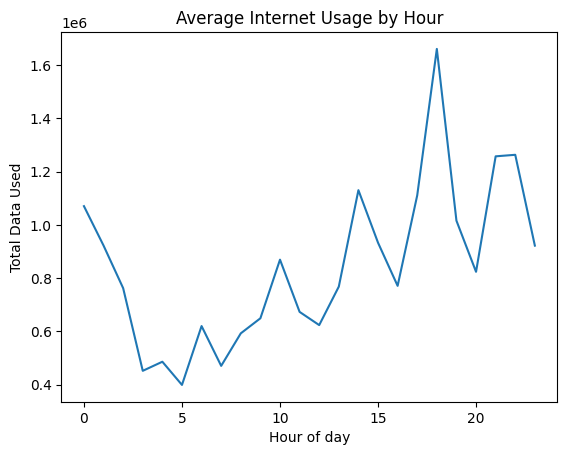

In [71]:
import matplotlib.pyplot as plt

avg_hourly = hourly.groupby('hour')['congestion'].mean()

plt.plot(avg_hourly)
plt.xlabel("Hour of day")
plt.ylabel("Total Data Used")
plt.title("Average Internet Usage by Hour")
plt.show()


From the graph it is clear that internet usage is highest between 3 PM to 8 PM. Hence Wi-Fi feels slow during this period.

In [72]:
hourly['prev_1h'] = hourly['congestion'].shift(1)
hourly['prev_3h'] = hourly['congestion'].rolling(3).mean()
hourly['is_weekend'] = pd.to_datetime(hourly['date']).dt.weekday >= 5

hourly.dropna(inplace=True)
hourly.head()


,date,hour,congestion,active_minutes,prev_1h,prev_3h,is_weekend
2,2022-05-10,2,698060.80,72.933333,173598.72,327168.000000,False
3,2022-05-10,9,890.04,5.000000,698060.80,290849.853333,False
4,2022-05-10,10,64788.48,30.000000,890.04,254579.773333,False
5,2022-05-10,11,482959.36,579.616667,64788.48,182879.293333,False
6,2022-05-10,13,360591.36,173.333333,482959.36,302779.733333,False


In [74]:
hourly['prev_6h'] = hourly['congestion'].rolling(6).mean()
hourly['prev_12h'] = hourly['congestion'].rolling(12).mean()
hourly['daily_avg'] = hourly.groupby('date')['congestion'].transform('mean')

hourly.dropna(inplace=True)


In [76]:
hourly['wli'] = (
    0.5 * hourly['congestion'] +
    0.3 * hourly['prev_1h'] +
    0.2 * hourly['prev_3h']
)



In [77]:
from sklearn.metrics import r2_score, mean_absolute_error

X = hourly[['hour','is_weekend','prev_1h','prev_3h','prev_6h','prev_12h','daily_avg']]
y = hourly['wli']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = RandomForestRegressor(n_estimators=300, random_state=0)
model.fit(X_train, y_train)

pred = model.predict(X_test)

print("R2:", r2_score(y_test, pred))
print("MAE:", mean_absolute_error(y_test, pred))


R2: 0.6766414845157886
MAE: 306116.8191170662


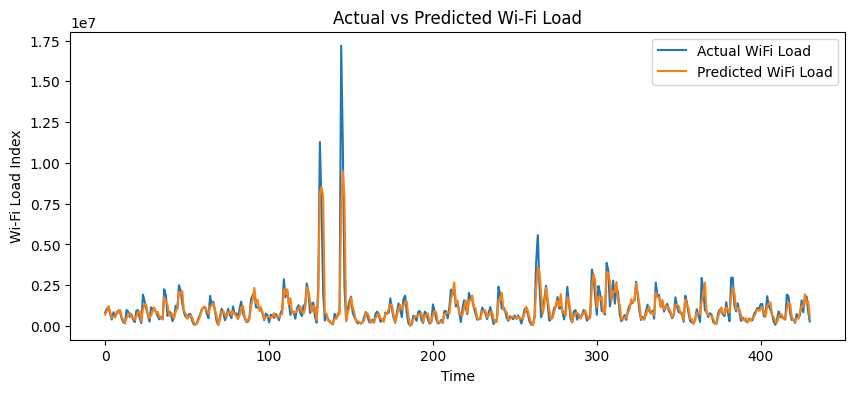

In [78]:
 plt.figure(figsize=(10,4))
plt.plot(y_test.values, label="Actual WiFi Load")
plt.plot(pred, label="Predicted WiFi Load")
plt.legend()
plt.title("Actual vs Predicted Wi-Fi Load")
plt.xlabel("Time")
plt.ylabel("Wi-Fi Load Index")
plt.show()


In [79]:
test_sample = X_test.iloc[0:5]
real_values = y_test.iloc[0:5]

predicted = model.predict(test_sample)

result = pd.DataFrame({
    'Actual WiFi Load': real_values.values,
    'Predicted WiFi Load': predicted
})

result


,Actual WiFi Load,Predicted WiFi Load
0,8.273906e+05,6.978386e+05
1,1.069659e+06,9.108952e+05
2,1.140389e+06,1.227665e+06
3,7.402431e+05,8.799254e+05
4,3.964607e+05,5.134517e+05
